<a href="https://colab.research.google.com/github/RafalCer/Machine_learning/blob/main/Regression_model_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
The present notebook presents and discusses the implementation of a regression model in Python from scratch. The contents of the notebook is as follows: 


1.   A brief description of the Regression_model class and code of its implementation
2.   A walkthrough of data preprocessing
1.   Search for best hyperparameters
2.   Implementation of different gradients on BoW model
3. Implementation of TFIDF model
4. A general comparison of the results.





# **The Regression_model class**

The whole model pipeline consists of four main functions defined in one class instance — Regression_model:


1.   **predict**: for predicting the sentiment of vectorized review
2.   **fit**: for fitting the regression model, which has 4 alternatives types of descent:
  *   Gradient Descent
  *   Stochastic Gradient Descent
  *   Stochastic Gradient Descent with Momentum
  *   Stochastic Gradient Descent with RMSprop
1.   **evaluate**: for evaluating the model on vectorized test/train data
2.   **cross_validation**: for 10-fold cross validation of the model 


Looking back at the assignment, perhaps defining the whole pipeline within a single class was not the best idea, since the code turned out highly verbose and clustered. Additionally, due to the lack of time, a few aspects, such as the convergence condition, were not implemented recursively for the present submission. Lastly, some functions, such as *objective_function* and *descent* were written out in a clearer manner (e.g. *if* statement instead of the implemented feature *max()*), as this enabled the author to tweak the model and ensure a proper understanding of the model for the author of the present submission.

In [ ]:
from itertools import cycle

class Regression_model:
  def __init__(self, learning_rate, dampening): 
    self.learning_rate = learning_rate
    self.dampening = dampening


  def predict(self, x_): #######################################################
      return np.sign(np.dot(self.omega.transpose(), x_))


  def fit(self, X_, y_, omega=None, print_loss=False, descent_type='GD',\
          m_iterations=300, n_batches=16, parameter_search = False):
    self.iterations, self.convergence_counter, self.descent = 0, 0, 0
    self.convergence_condition = False
    self.losses = []
    self.omega = np.random.normal(0, 1, size=(X_.shape[1]))
    if omega:
      self.omega = omega
    self.best_omega = self.omega
    self.parameter_search = parameter_search
    
    def objective_function(): # calculation of hinge loss
      total_loss = 0
      regularization = self.dampening / 2 * (np.square(np.linalg.norm(self.omega)))
      for review in range(X_.shape[0]):
        y_hat = np.dot(self.omega, X_[review, :])
        instance_loss = 1 - (y_[review] * y_hat)
        if instance_loss > 0:
          total_loss += instance_loss
        else:
          continue

      return regularization + total_loss

    def gradient(x_set, y_set): # calculation of gradient change
      temp = np.zeros(x_set.shape[1])
      for review in range(x_set.shape[0]):
        y_hat = np.dot(self.omega, x_set[review, :])
        correct_y = y_set[review]
        if y_hat * correct_y >= 1:
          continue
        else:
          temp -= x_set[review, :]  * correct_y
      
      return (self.omega * self.dampening + temp)

    def gradient_descent(): ####################### GD #########################
      while not self.convergence_condition and self.iterations <= m_iterations: 
        self.omega = self.omega - gradient(X_, y_) * self.learning_rate
        loss = objective_function()
        self.losses.append(float(loss))
        if print_loss:
          print(f'Epoch {len(self.losses)} \t loss: {loss}')
        if len(self.losses) >= 2:
          if loss <= min(self.losses):
            self.best_omega = self.omega
          if self.losses[self.iterations] > self.losses[self.iterations-1] - 0.01 :
            self.convergence_counter += 1
            if self.convergence_counter == 5:
              self.convergence_condition = True
          else:
            self.convergence_counter = 0
        self.iterations += 1
      if print_loss:
        print(f'best loss achieved: {min(self.losses)} \t it took {self.iterations} iterations')

      if self.parameter_search:
        return min(self.losses), len(self.losses), self.best_omega


    def stochastic_gradient_descent(): ################### SGD #################
        data_batches = [X_[batch::n_batches, :] for batch in range(n_batches)] # splitting the data into batches by taking every 16th review
        label_batches = [y_[batch::n_batches] for batch in range(n_batches)]
        batches_cycle = cycle(range(len(data_batches))) # rotating through n batches
        while not self.convergence_condition and self.iterations <= m_iterations:
          batch_index = next(batches_cycle)

          self.omega = self.omega - gradient(data_batches[batch_index], label_batches[batch_index]) * self.learning_rate

          if batch_index == n_batches-1: # every 16 batches 
            loss = objective_function() # calculate the loss
            self.losses.append(float(loss))
            if print_loss:
              print(f'Epoch {len(self.losses)} \t loss: {loss}')
            if len(self.losses) >= 2:
              if loss <= min(self.losses):
                self.best_omega = self.omega
              if self.losses[self.iterations] > self.losses[self.iterations-1] - 0.01 :
                self.convergence_counter += 1
                if self.convergence_counter == 5:
                  self.convergence_condition = True
              else:
                self.convergence_counter = 0
            self.iterations += 1
        if print_loss:
          print(f'best loss achieved: {min(self.losses)} \t it took {self.iterations} iterations')

    def sgd_momentum(): ############## SGD with momentum of 0.9 ################ 
        data_batches = [X_[batch::n_batches, :] for batch in range(n_batches)]
        label_batches = [y_[batch::n_batches] for batch in range(n_batches)]
        batches_cycle = cycle(range(len(data_batches))) 
        while not self.convergence_condition and self.iterations <= m_iterations:
          batch_index = next(batches_cycle)

          gradient_change = gradient(data_batches[batch_index], label_batches[batch_index]) * self.learning_rate
          self.descent = 0.9 * self.descent + gradient_change
          self.omega = self.omega - self.descent

          if batch_index == n_batches-1: # every 16 batches 
            loss = objective_function()
            self.losses.append(float(loss))
            if print_loss:
              print(f'Epoch {len(self.losses)} \t loss: {loss}')
            if len(self.losses) >= 2:
              if loss <= min(self.losses):
                self.best_omega = self.omega
              if self.losses[self.iterations] > self.losses[self.iterations-1] - 0.01 :
                self.convergence_counter += 1
                if self.convergence_counter == 5:
                  self.convergence_condition = True
              else:
                self.convergence_counter = 0
            self.iterations += 1
        if print_loss:
            print(f'best loss achieved: {min(self.losses)} \t it took {self.iterations} iterations')

        self.omega = self.best_omega
        return self.omega

    def sgd_rmsprop():##################### SGD RMSprop ######################## 
        self.descent = 0
        data_batches = [X_[batch::n_batches, :] for batch in range(n_batches)]
        label_batches = [y_[batch::n_batches] for batch in range(n_batches)]
        batches_cycle = cycle(range(len(data_batches)))
        while not self.convergence_condition and self.iterations <= m_iterations:
          batch_index = next(batches_cycle)

          gradient_change = gradient(data_batches[batch_index], label_batches[batch_index]) * self.learning_rate

          self.descent = 0.9 * self.descent + 0.1 * np.square(gradient_change)
          self.omega = self.omega - (self.learning_rate / np.sqrt(self.descent) * gradient_change)

          if batch_index == n_batches-1: # every 16 batches 
            loss = objective_function()
            self.losses.append(float(loss))
            if print_loss:
              print(f'Epoch {len(self.losses)} \t loss: {loss}')
            if len(self.losses) >= 2:
              if loss <= min(self.losses):
                self.best_omega = self.omega
              if self.losses[self.iterations] > self.losses[self.iterations-1] - 0.01 :
                self.convergence_counter += 1
                if self.convergence_counter == 5:
                  self.convergence_condition = True
              else:
                self.convergence_counter = 0
            self.iterations += 1
        if print_loss:
          print(f'best loss achieved: {min(self.losses)} \t it took {self.iterations} iterations')

        self.omega = self.best_omega
        return self.omega
      
    if descent_type == 'GD':
      if self.parameter_search:
        return gradient_descent()
      else: 
        gradient_descent()
    elif descent_type == 'SGD':
      stochastic_gradient_descent()
    elif descent_type == 'momentum':
      sgd_momentum()
    elif descent_type == 'rmsprop':
      sgd_rmsprop()

  def evaluate(self, X_, y_, print_score=False): ###############################
    guessed_correctly, guesses = 0, 0
    self.omega = self.best_omega
    for review in range(X_.shape[0]):
      y_hat = self.predict(X_[review, :])
      if y_hat == y_[review]:
        guessed_correctly += 1
      guesses += 1

    if print_score:
      print(f'guesses: {guesses} \t guessed_correctly: {guessed_correctly} ')
      print(f'the accuracy for the test set is: {guessed_correctly/guesses}')

    return guessed_correctly / guesses


  def cross_validation(self, X_, y_): ##########################################
    score = 0
    self.omega = np.random.normal(0, 1, size=(X_.shape[1]))
    validation_omega = self.omega.copy()
    for i in range(10):
      self.omega = validation_omega.copy()
      print(f'current stage of cross-validation: {i+1}')
      testing_set_ = X_[i::5, :] # every 5th element (20%) is added to the testing set
      testing_labels_ = y_[i::5] # every 5th element is deleted from the training data
      training_set_ = np.delete(X_, list(range(i, X_.shape[0], 5)), axis=0)
      training_labels_ = np.delete(y_, np.arange(i, y_.size, 5))

      fitted_hyperplane = self.fit(training_set_, training_labels_)
      score += self.evaluate(testing_set_, testing_labels_)

    final_score = score/10
    print(f'The average score after the cross-validation is {final_score}')

    return final_score


# **Data pre-processing**

Step 1, importing the reviews.



In [ ]:
!wget -N http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

--2021-04-21 22:46:48--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘review_polarity.tar.gz’ not modified on server. Omitting download.



Step 2, extracting the reviews, cleaning up and tokenizing the raw text.

Once the reviews are tokenized and stripped of non-alphanumeric characters, the tokenized reviews are stored in a np array *X_tokenized*. The sentiment, or, in other words, the labels of reviews are stored in an array *y*, where -1 corresponds to negative sentiment, while 1 corresponds to positive. 

In [ ]:
import numpy as np
import os
import tarfile

tar = tarfile.open('review_polarity.tar.gz')
tar.extractall()
tar.close()

X_raw = np.array([])
X_tokenized = np.array([])
y = np.array([])
vocabulary = set()

for reviews_dir in os.listdir('txt_sentoken'):
  reviews = os.listdir(f'./txt_sentoken/{reviews_dir}')
  for index_review, review in enumerate(reviews):
    with open('./txt_sentoken/' + reviews_dir + '/' + review, 'r') as infile:
        review_text_raw = infile.read() # extract the raw review
        review_text = review_text_raw.replace('\n', '') # clean the text from the newline symbol
        review_text = set(review_text.split(' ')) # simple tokenization using whitespace
        review_text = [token for token in review_text if token.isalnum()] # getting rid of non alpha-numeric toens
        X_raw = np.append(X_raw, review_text)
        X_tokenized = np.append(X_tokenized, set(review_text)) # append the tokenized and pre-processed set (corresponding to a review) to a vetor storing all pre-processed reviews
        if reviews_dir.startswith('p'): # --- positive review
            y = np.append(y, 1)                             
            vocabulary.update(set(review_text)) # add the unique tokens to the vocabulary set
        elif reviews_dir.startswith('n'):# --- negative review
            y = np.append(y, -1) 
            vocabulary.update(set(review_text))

vocabulary = list(sorted(vocabulary)) # turn the vocabulary into a list so that it can be sorted

Step 3, turning reviews into **binary BoW vectors** and adding a pseudo input of 1 in each vector to account for bias. 

*This part usually runs for roughly 8 minutes.*

In [ ]:
def bow_matrix_population(X_, vocabulary_):
  data_matrix = np.zeros((len(X_), len(vocabulary_)), dtype=int)
  for review_index, review in enumerate(X_):
    print(f'currently processing review number {review_index + 1}')
    for word in list(review):
      data_matrix[review_index, vocabulary_.index(word)] = 1
  data_matrix = np.insert(data_matrix, 0, 1, axis=1) # 1 in every vector to account for bias

  return data_matrix

X = bow_matrix_population(X_tokenized, vocabulary)

Step 4, splitting the data into *training* (80%) and **test** (20%) set. Half of the reviews in both sets are positive, the other half negative. 

*The chosen method of splitting is very limited and chosen specifically for the given size of data sets and it's positioning in the matrix. A much more effective way is implemented for splitting data into batches within the Regression_model class.* 

In [ ]:
def naive_splitting(X_, y_):
  training_data = X_[:800, :]
  training_data = np.concatenate((training_data, X_[1200:, :]), axis=0)
  training_labels = y_[:800]
  training_labels = np.append(training_labels, y_[1200:])
  testing_data = X_[800:1200, :]
  testing_labels = y_[800:1200] # the range is chosen because it includes an equal proportion of positive and negative reviews

  return training_data, training_labels, testing_data, testing_labels

bow_training_data, bow_training_labels, bow_testing_data, bow_testing_labels = naive_splitting(X, y_sentiment)

Step 5, choice of **omega** (feature vecture).

*Generally, a model with an initial feature vector generated using normal distribution (the first option below) tends to converge faster.*

In [ ]:
omega = np.random.normal(0, 1, size=(X.shape[1])) 

#omega = np.ones(len(X))

#omega = np.random.uniform(low=-10.0, high=10.0, size=len(X))

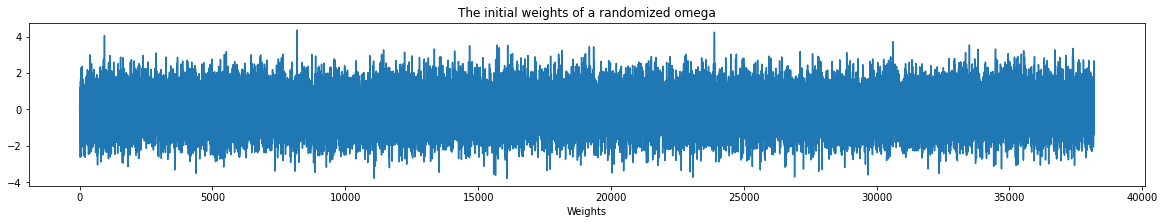

In [ ]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(omega[1:])
plt.xlabel("Value")
plt.xlabel("Weights")
plt.title("The initial weights of a randomized omega")
plt.show()

Step 6, choice of **hyperparameters**. 

Due to a very limited computational power of the author, only 10 sets of hyperparameters were tested. The results can be seen a few blocks below, the best hyperparameters generally appear to be within the range of 0.003 and 0.09 for both the *learning rate* and the *dampening* parameter.


It should be noted that the convergence was limited to 150 iterations at most for all the tested hyperparameters due to limited time and computational resources. Additionally, it is likely that the higher parameters failed because of an additional convergence condition, since if the loss goes up 5 times in a row, the fitting process is cancelled. It goes without saying that this is not a good condition for practical application.

In [ ]:
import pandas as pd

dampen_parameter_sample = np.exp(np.linspace(np.log(0.0001), np.log(3), 10))
learn_rate_sample = np.exp(np.linspace(np.log(0.0001), np.log(3), 10))


def sample_test(X_train, y_train, X_test, y_test):
  results_dict = {'Dampening parameter': [], 'Learn rate': [], 'Epochs': [], 'Lowest loss': [], 'Accuracy on train set': [], 'Accuracy on test set': []}

  for i in range(len(dampen_parameter_sample)):
    omega_ = np.random.normal(0, 1, size=(X_train.shape[1]))
    model = Regression_model(dampening = dampen_parameter_sample[i], learning_rate = learn_rate_sample[i])
    fitted_omega, lowest_loss, epochs = model.fit(X_train, y_train, omega_, m_iterations=150, parameter_search=True)
    score_on_train = model.evaluate(X_train, y_train)
    score_on_test = model.evaluate(X_test, y_test)

    results_dict['Dampening parameter'].append(dampen_parameter_sample[i])
    results_dict['Learn rate'].append(learn_rate_sample[i])
    results_dict['Epochs'].append(epochs)
    results_dict['Lowest loss'].append(lowest_loss)
    results_dict['Accuracy on train set'].append(score_on_train)
    results_dict['Accuracy on test set'].append(score_on_test)

  return results_dict

hyperparameters = sample_test(bow_training_data, bow_training_labels, bow_testing_data, bow_testing_labels)


In [ ]:
hyperparameters_table = pd.DataFrame.from_dict(hyperparameters)
print(hyperparameters_table)

   Dampening parameter  Learn rate  ... Accuracy on train set  Accuracy on test set
0             0.000100    0.000100  ...              0.685000                0.5975
1             0.000314    0.000314  ...              0.867500                0.6675
2             0.000988    0.000988  ...              0.883125                0.7000
3             0.003107    0.003107  ...              0.998750                0.7925
4             0.009769    0.009769  ...              0.999375                0.8225
5             0.030711    0.030711  ...              1.000000                0.8175
6             0.096549    0.096549  ...              1.000000                0.8250
7             0.303533    0.303533  ...              0.500000                0.5000
8             0.954253    0.954253  ...              0.500000                0.5000
9             3.000000    3.000000  ...              0.500000                0.5000

[10 rows x 6 columns]


The hyperparameters test established that the the most accurate model on involves having both dampening parameter and learn rate of 0.09.

According to the literature, small learning rate and dampen parameter are often preferred for training a model. Nevertheless, it is often added that for large scale tasks, having a semi-big hyperparameters might considerably lower the computational time and might even result in a better result. That, however, highly depends on the application area as well as the model used, along with countless other factors. 

# **BoW model fitting**

This section of notebook will contain an attempt at analysing the results of the parameters. Where possible and, the data will be visualised.

**Gradient Descent** is often referred to as one of the most simple learning algorithms, as no data has to be pooled and it does not involve much normalization. As a result, fitting a model using gradient descent often takes a while, especially if the data set is large. As seen below, with a decent set of hyperparameters, the loss decreases steadily, yet slowly. 

In [ ]:
bow_model = Regression_model(0.096549, 0.030711)
bow_model.fit(bow_training_data, bow_training_labels, descent_type='GD', print_loss=True)

Epoch 1 	 loss: 2794343.635571402
Epoch 2 	 loss: 1600613.784400516
Epoch 3 	 loss: 2798422.9341675355
Epoch 4 	 loss: 1460442.5667042853
Epoch 5 	 loss: 2802880.445061544
Epoch 6 	 loss: 1321501.3495971523
Epoch 7 	 loss: 2807709.177608013
Epoch 8 	 loss: 1183778.1267530588
Epoch 9 	 loss: 2812902.238656166
Epoch 10 	 loss: 1047261.0187084458
Epoch 11 	 loss: 2818452.831310124
Epoch 12 	 loss: 912217.0118403538
Epoch 13 	 loss: 2811032.069566425
Epoch 14 	 loss: 795113.9177016319
Epoch 15 	 loss: 2702065.4277558313
Epoch 16 	 loss: 787476.5719389024
Epoch 17 	 loss: 2519719.4800384403
Epoch 18 	 loss: 855314.5368266235
Epoch 19 	 loss: 2326452.0758147594
Epoch 20 	 loss: 935391.2869673123
Epoch 21 	 loss: 2152818.5748944525
Epoch 22 	 loss: 997320.424801694
Epoch 23 	 loss: 1939735.4630975926
Epoch 24 	 loss: 1099950.8430787122
Epoch 25 	 loss: 1799593.0510341576
Epoch 26 	 loss: 1131144.4914974421
Epoch 27 	 loss: 1576029.6835831457
Epoch 28 	 loss: 1233513.5733602627
Epoch 29 	 loss

Though it runs for over 300 epochs, the model still has a significant loss, which implies that it will likely perform poorly on the test data set. As can be seen below, this is exactly the case: 


In [ ]:
train_accuracy = bow_model.evaluate(bow_training_data, bow_training_labels)
test_accuracy = bow_model.evaluate(bow_testing_data, bow_training_labels)

print(f'Accuracy on the training set:\t {train_accuracy}')
print(f'Accuracy on the testing set:\t {test_accuracy}')

Accuracy on the training set:	 1.0
Accuracy on the testing set:	 0.585


Despite the low accuracy though, the model appears to be able to properly estimate the sentiment of numerous words. 

As seen from the graph below, the model correctly identifies *stupid*, *unfortunately*, *boring*, *worst*, and *bad* as negative words. *Well*, *great*, *perfect*, and *best*, on the other hand, are classified as having highly positive sentiment, which is undoubtedly correct. 

In [ ]:
idx = np.argsort(np.abs(bow_model.omega[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:
  print("%20s   %.3f\t%i " % (vocabulary[i], bow_model.omega[i+1], np.sum([vocabulary[i] in d for d in X_raw])))

                Word   Weight  Occurences
                also   62.808	1070 
                well   63.049	1169 
               great   63.136	936 
                 see   63.188	3610 
                 why   -64.447	581 
                both   65.382	703 
                mess   -69.105	340 
             perfect   69.176	456 
                best   71.482	859 
              stupid   -72.197	243 
                have   -73.452	1688 
            supposed   -75.149	330 
       unfortunately   -75.574	329 
               looks   -79.176	364 
              boring   -85.806	230 
             nothing   -91.001	592 
                plot   -92.136	1138 
              script   -92.194	664 
               worst   -94.818	237 
                 bad   -139.020	870 


Lastly, the distribution of weights across positive and negative sentiments appears more or less equal, arguably leaning to the negative side.

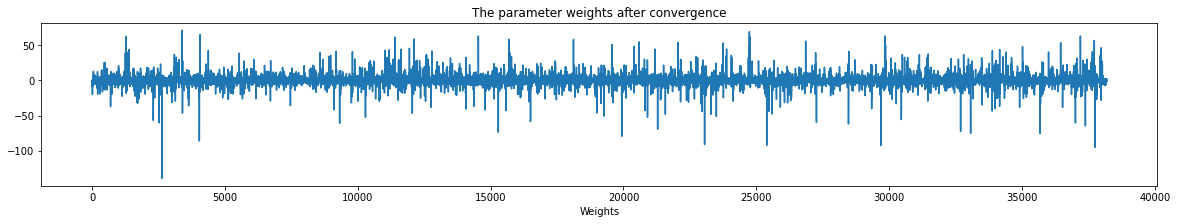

In [ ]:
plt.figure(figsize=(20, 3))
plt.plot(bow_model.best_omega[1:])
plt.xlabel("Value")
plt.xlabel("Weights")
plt.title("The parameter weights after convergence")
plt.show()

Overall, even though Gradient Descent model does not learn quickly, it succeeds in capturing the sentiments of the words more or less accurately. 

An updated version, **Stochastic Gradient Descent**, addresses the issue of time and computation complexity. Instead of ~500 epoch, which was a commonly observed time of convergence for Gradient Descent on low learning rate and dampening parameter, SGD can easily converge in 50. Moreover, it often decreases the loss in just 10 epochs to a value that GD cannot reach in 500.

An example of the quick convergence can be seen below.

In [ ]:
bow_model_sgd = Regression_model(0.096549, 0.030711)
bow_model_sgd.fit(bow_training_data, bow_training_labels, print_loss=True, descent_type='SGD')

Epoch 1 	 loss: 159933.40439175008
Epoch 2 	 loss: 88607.28937591288
Epoch 3 	 loss: 41093.66513425763
Epoch 4 	 loss: 4265.890134307436
Epoch 5 	 loss: 2279.734620214984
Epoch 6 	 loss: 1339.903181748295
Epoch 7 	 loss: 836.5298332646803
Epoch 8 	 loss: 584.2150109369032
Epoch 9 	 loss: 507.71346871502044
Epoch 10 	 loss: 436.338633354093
Epoch 11 	 loss: 388.86415386508753
Epoch 12 	 loss: 352.92269754702096
Epoch 13 	 loss: 320.7397714487405
Epoch 14 	 loss: 291.6648710671536
Epoch 15 	 loss: 265.22559591028033
Epoch 16 	 loss: 241.18302786545382
Epoch 17 	 loss: 219.31990662781115
Epoch 18 	 loss: 199.43866643081356
Epoch 19 	 loss: 181.35965074616468
Epoch 20 	 loss: 164.9194888202936
Epoch 21 	 loss: 149.96961937699442
Epoch 22 	 loss: 136.37494814568603
Epoch 23 	 loss: 124.01262708406612
Epoch 24 	 loss: 112.77094426362318
Epoch 25 	 loss: 102.5483143864726
Epoch 26 	 loss: 93.25236081133933
Epoch 27 	 loss: 84.79908079342674
Epoch 28 	 loss: 77.11208639487558
Epoch 29 	 loss: 

Interestingly enough though, the model learn so fast it actually overlearns in an instance. Even though the loss is low as ever, the model's performance on a test set is very with an accuracy of less than 50%. In comparison to GD though, the weights are much more contained and more or less eavenly distributed between -3 and 3. 

Lastly, a look at the word with the highest positive and negative weights reveals that SGD manages to identify them properly. 

Accuracy on the training set:	 0.974375
Accuracy on the testing set:	 0.4475


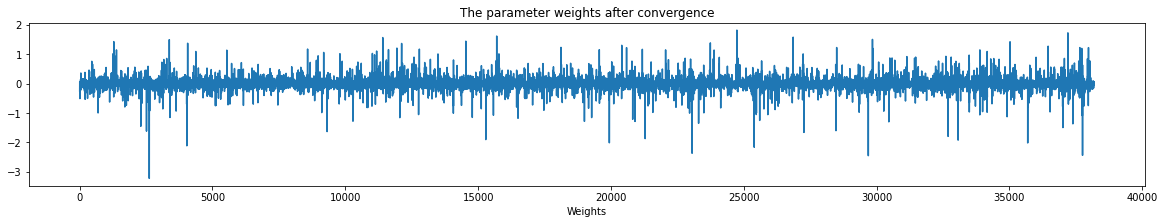

In [ ]:
train_accuracy = bow_model_sgd.evaluate(bow_training_data, bow_training_labels)
test_accuracy = bow_model_sgd.evaluate(bow_testing_data, bow_training_labels)

print(f'Accuracy on the training set:\t {train_accuracy}')
print(f'Accuracy on the testing set:\t {test_accuracy}')

plt.figure(figsize=(20, 3))
plt.plot(bow_model_sgd.best_omega[1:])
plt.xlabel("Value")
plt.xlabel("Weights")
plt.title("The parameter weights after convergence")
plt.show()

In [ ]:
idx = np.argsort(np.abs(bow_model_sgd.omega[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:
  print("%20s   %.3f\t%i " % (vocabulary[i], bow_model_sgd.omega[i+1], np.sum([vocabulary[i] in d for d in X_raw])))

                Word   Weight  Occurences
           hilarious   2.910	194 
               awful   -2.980	162 
                best   2.992	859 
          ridiculous   -3.048	167 
            director   -3.081	938 
             perfect   3.233	456 
                well   3.238	1169 
              reason   -3.281	548 
                mess   -3.372	340 
                have   -3.523	1688 
              stupid   -3.549	243 
            supposed   -3.552	330 
       unfortunately   -3.684	329 
                plot   -3.715	1138 
              boring   -3.756	230 
               looks   -3.821	364 
               worst   -4.371	237 
              script   -4.409	664 
             nothing   -4.833	592 
                 bad   -6.333	870 


Stochastic gradient descent can be further improved by adding **momentum**, which is often visualised as rolling boulder whose velocity keeps increasing. Weights of parameters are adjusted recursively by considering the current and the last gradients, thus resulting in an impressive speed of learning. 

As seen below, the model improves nearly exponentially. Nevertheless, this highly depends on the selected hyperparameters, as raising the learning rate to, for instance, 0.03 often results in the model spiking up and down, never actually bringing the loss down to a reasonable value. 

In [ ]:
bow_model_momentum = Regression_model(0.096549, 0.0030711)
bow_model_momentum.fit(bow_training_data, bow_training_labels, print_loss=True, descent_type='momentum')

Epoch 1 	 loss: 50503.48956639388
Epoch 2 	 loss: 31173.391683225927
Epoch 3 	 loss: 13066.894510080618
Epoch 4 	 loss: 4559.363657888435
Epoch 5 	 loss: 3924.7837197994245
Epoch 6 	 loss: 2246.9001539691844
Epoch 7 	 loss: 1002.0349417769897
Epoch 8 	 loss: 920.0449156107311
Epoch 9 	 loss: 837.6843207837795
Epoch 10 	 loss: 760.525117561037
Epoch 11 	 loss: 689.8861390170757
Epoch 12 	 loss: 625.6911843989706
Epoch 13 	 loss: 567.4476639761382
Epoch 14 	 loss: 514.6217507560702
Epoch 15 	 loss: 466.7128493577146
Epoch 16 	 loss: 423.26390426577257
Epoch 17 	 loss: 383.8598417606942
Epoch 18 	 loss: 348.1241244276433
Epoch 19 	 loss: 315.7152493718575
Epoch 20 	 loss: 286.3235025499572
Epoch 21 	 loss: 259.66800230869984
Epoch 22 	 loss: 235.49401575791856
Epoch 23 	 loss: 213.57052453304553
Epoch 24 	 loss: 193.68801709238542
Epoch 25 	 loss: 175.6564865268558
Epoch 26 	 loss: 159.30361476229507
Epoch 27 	 loss: 144.4731258042871
Epoch 28 	 loss: 131.02329228879202
Epoch 29 	 loss: 1

Momentum achieves an impressive loss of only 0.5447664397025246 in few iterations. Nevertheless, it tends to highly overlearn. Interestingly enough, the bigest weights are very close to those seen from the previous models.

In [ ]:
train_accuracy = bow_model_momentum.evaluate(bow_training_data, bow_training_labels)
test_accuracy = bow_model_momentum.evaluate(bow_testing_data, bow_training_labels)

print(f'Accuracy on the training set:\t {train_accuracy}')
print(f'Accuracy on the testing set:\t {test_accuracy}')
print(f'')

idx = np.argsort(np.abs(bow_model_momentum.omega[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:
  print("%20s   %.3f\t%i " % (vocabulary[i], bow_model_momentum.omega[i+1], np.sum([vocabulary[i] in d for d in X_raw])))

Accuracy on the training set:	 1.0
Accuracy on the testing set:	 0.4875

                Word   Weight  Occurences
        entertaining   1.002	265 
        performances   1.025	368 
               maybe   -1.026	272 
             attempt   -1.043	505 
               waste   -1.062	266 
           hilarious   1.085	194 
              wasted   -1.095	111 
                mess   -1.175	340 
               looks   -1.200	364 
               awful   -1.240	162 
          ridiculous   -1.257	167 
            supposed   -1.292	330 
                plot   -1.331	1138 
              script   -1.343	664 
                have   -1.344	1688 
       unfortunately   -1.374	329 
               worst   -1.467	237 
              boring   -1.575	230 
             nothing   -1.752	592 
                 bad   -1.763	870 


Lastly, **RMSprop**. As any other addition to Stochastic Gradient Descent, it learns quickly, yet bears the risk of overlearning and therefore not performing as well on a test set. In the example below, the parameters were tuned down in comparison to momentum and SGDm as RMSprop would reach a loss close to 0 in as few as 5 epochs. 

In [ ]:
bow_model_rms = Regression_model(0.0096549, 0.0030711)
bow_model_rms.fit(bow_training_data, bow_training_labels, descent_type='rmsprop', print_loss=True)

Epoch 1 	 loss: 8265.970916239397
Epoch 2 	 loss: 6151.19128558975
Epoch 3 	 loss: 4477.8896787833055
Epoch 4 	 loss: 3230.381611123908
Epoch 5 	 loss: 2232.706201211315
Epoch 6 	 loss: 1483.9663835462381
Epoch 7 	 loss: 947.7200196226379
Epoch 8 	 loss: 570.1324562388714
Epoch 9 	 loss: 290.2840462917985
Epoch 10 	 loss: 167.83061704745398
Epoch 11 	 loss: 109.90291056197776
Epoch 12 	 loss: 110.78660808715522
Epoch 13 	 loss: 46.254368270611096
Epoch 14 	 loss: 38.503382850413956
Epoch 15 	 loss: 38.50467446337569
Epoch 16 	 loss: 27.154737730898212
Epoch 17 	 loss: 27.301269510245838
Epoch 18 	 loss: 39.00926147073015
Epoch 19 	 loss: 36.258789744199916
Epoch 20 	 loss: 139.57906988710667
Epoch 21 	 loss: 22.928200228790764
Epoch 22 	 loss: 27.16274976961988
Epoch 23 	 loss: 38.27168047350864
Epoch 24 	 loss: 20.892168340955386
Epoch 25 	 loss: 19.206231414211267
Epoch 26 	 loss: 22.401668163649177
Epoch 27 	 loss: 14.13555222973126
Epoch 28 	 loss: 18.40721905343835
Epoch 29 	 loss

As most of the fast learning algorithms, it overlearns significantly. Perhaps it would reach a higher score on the test if the hyperparameters were tuned down even more.

In [ ]:
train_accuracy = bow_model_rms.evaluate(bow_training_data, bow_training_labels)
test_accuracy = bow_model_rms.evaluate(bow_testing_data, bow_training_labels)

print(f'Accuracy on the training set:\t {train_accuracy}')
print(f'Accuracy on the testing set:\t {test_accuracy}')
print(f'')

idx = np.argsort(np.abs(bow_model_rms.omega[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:
  print("%20s   %.3f\t%i " % (vocabulary[i], bow_model_rms.omega[i+1], np.sum([vocabulary[i] in d for d in X_raw])))

Accuracy on the training set:	 1.0
Accuracy on the testing set:	 0.5425

                Word   Weight  Occurences
                mess   -1.372	340 
               point   -1.398	1090 
                  10   -1.400	222 
               maybe   -1.411	272 
              trying   -1.424	441 
            material   -1.428	228 
               waste   -1.475	266 
                 bad   -1.476	870 
             perfect   1.509	456 
                side   1.512	1549 
            supposed   -1.518	330 
                only   -1.582	1317 
                  is   1.655	21487 
                 but   1.661	2299 
       unfortunately   -1.672	329 
             overall   1.714	146 
              script   -1.719	664 
              boring   -1.720	230 
             nothing   -1.784	592 
              family   1.848	347 


To summarize, it seems that RMSprop was able to cut down the loss the quickest. Nevertheless, just like momentum and SGD, it overlearned, a lot.

Gradient Descent on the other hand was the slowest. However, if it was allowed to take its time with the epochs, its accuracy was pretty impressive even on the test set, as it at times reached the precision of 85%. 

# **TF-IDF implementation**

Bag of Words models are often seen as primitive and unable to adequately asses the salience of a word within the text. As a result, numerous stopwords may affect the decision boundry of a classifier even though they have barely any sentiment.

This issue is addressed by **tf-idf model**, where each word is given its weight relative to the documents it occurs in as well as other words within the document. 

As part of this submission, I chose to implement the simplest version of tf-idf model, one that does not include normalization with log. 

Below is the code for extracting and pre-processing raw data into vectors with tf-idf scores. 

In [ ]:
import numpy as np
import os
import tarfile

tar = tarfile.open('review_polarity.tar.gz')
tar.extractall()
tar.close()

X_raw = np.array([])
X_tf = np.array([]) # term frequencies 
X_review_lengths = np.array([]) # component of the idf score
y_sentiment = np.array([]) 
vocabulary = set() 
idf_dictionary = dict()

for reviews_dir in os.listdir('txt_sentoken'):
  reviews = os.listdir(f'./txt_sentoken/{reviews_dir}')
  for index_review, review in enumerate(reviews):
    with open('./txt_sentoken/' + reviews_dir + '/' + review, 'r') as infile:
        review_text = infile.read()                                             # extract the raw review
        clean_text = review_text.replace('\n', '')                              # clean the text from the newline thing
        clean_text = clean_text.split(' ')
        clean_text = [element for element in clean_text if element.isalnum()]
        X_review_lengths = np.append(X_review_lengths, len(clean_text))
        review_dictionary = dict()
        for term in clean_text:
          if term not in review_dictionary.keys():
            review_dictionary[term] = 1
          else:
            review_dictionary[term] += 1
        for term in set(clean_text):
          if term not in idf_dictionary:
            idf_dictionary[term] = 1
          else:
            idf_dictionary[term] += 1
        X_raw = np.append(X_raw, clean_text)
        X_tf = np.append(X_tf, review_dictionary)
        if reviews_dir.startswith('p'):                                         # positive review
            y_sentiment = np.append(y_sentiment, 1)                             # add 1 - positive sentiment marker - to the y axis
            vocabulary.update(set(clean_text))                                   # add the unique tokens to the vocabulary set
        elif reviews_dir.startswith('n'):                                       #negative review
            y_sentiment = np.append(y_sentiment, -1) 
            vocabulary.update(set(clean_text))

vocabulary = list(sorted(vocabulary))

X_tfidf = np.zeros((len(X_tf), len(vocabulary)), dtype=float)

Vectorization: 

*This part tends to run for roughly 15 minutes.*

In [ ]:
import math

for review_index, review in enumerate(X_tf):
  print(f'currently processing review number {review_index + 1}')
  for word in review.keys():
    term_frequency = review[word] / X_review_lengths[review_index]
    inverted_document_frequency = math.log(len(X_tf) / idf_dictionary[word])
    tfidf = term_frequency * inverted_document_frequency
    X_tfidf[review_index, vocabulary.index(word)] = tfidf

X_tfidf = np.insert(X_tfidf, 0, 1, axis=1) # adding the pseudo 1 (bias)

currently processing review number 1
currently processing review number 2
currently processing review number 3
currently processing review number 4
currently processing review number 5
currently processing review number 6
currently processing review number 7
currently processing review number 8
currently processing review number 9
currently processing review number 10
currently processing review number 11
currently processing review number 12
currently processing review number 13
currently processing review number 14
currently processing review number 15
currently processing review number 16
currently processing review number 17
currently processing review number 18
currently processing review number 19
currently processing review number 20
currently processing review number 21
currently processing review number 22
currently processing review number 23
currently processing review number 24
currently processing review number 25
currently processing review number 26
currently processing 

In [ ]:
tfidf_training_data, tfidf_training_labels, tfidf_testing_data, tfidf_testing_labels = naive_splitting(X_tfidf, y_sentiment)

# **TF-IDF model fitting**

Though the model using tf-idf is mostly stable, as the loss goes down steadily, it cuts down the loss slowly. From the few tests conducted, a BoW model would always converge earlier. 

In [ ]:
tf_model = Regression_model(0.1, 0.03)
tf_model.fit(tfidf_training_data, tfidf_training_labels, print_loss=True)

Epoch 1 	 loss: 2165.278533828413
Epoch 2 	 loss: 2154.8534371993583
Epoch 3 	 loss: 2144.490797324213
Epoch 4 	 loss: 2134.190240024559
Epoch 5 	 loss: 2123.9513933636863
Epoch 6 	 loss: 2113.773887633157
Epoch 7 	 loss: 2103.657355339461
Epoch 8 	 loss: 2093.6014311907365
Epoch 9 	 loss: 2083.6057520835902
Epoch 10 	 loss: 2073.669957089968
Epoch 11 	 loss: 2063.7936874441602
Epoch 12 	 loss: 2053.976586529795
Epoch 13 	 loss: 2044.2182998670114
Epoch 14 	 loss: 2034.5184750996195
Epoch 15 	 loss: 2024.8767619824139
Epoch 16 	 loss: 2015.2928123684915
Epoch 17 	 loss: 2005.7662801967067
Epoch 18 	 loss: 1996.2968214791608
Epoch 19 	 loss: 1986.884094288794
Epoch 20 	 loss: 1977.5277587470232
Epoch 21 	 loss: 1968.2274770114846
Epoch 22 	 loss: 1958.9829132638256
Epoch 23 	 loss: 1949.7937336975735
Epoch 24 	 loss: 1940.6596065061071
Epoch 25 	 loss: 1931.5802018706413
Epoch 26 	 loss: 1922.5551919483505
Epoch 27 	 loss: 1913.5842508605017
Epoch 28 	 loss: 1904.6670546807109
Epoch 29 

In [ ]:
tf_train_accuray = tf_model.evaluate(tfidf_training_data, tfidf_training_labels, print_score=True)
tf_test_accuracy = tf_model.evaluate(tfidf_testing_data, tfidf_testing_labels, print_score=True)

print(tf_train_accuray)
print(tf_test_accuracy)

guesses: 1600 	 guessed_correctly: 1304 
the accuracy for the test set is: 0.815
guesses: 400 	 guessed_correctly: 249 
the accuracy for the test set is: 0.6225
0.815
0.6225


In general, tf-idf model performs similarly to that of BoW, even though it converges slower. It does not reach an impressive precission, but it might be due to the fact that no normalization was used in the calculation of tf-idf scores.

# **Cross-validation**

The last feature to be discussed is 10-fold cross validation implemented as part of the regression model. The validation is excellent means for evaluating a model, for it eliminates the possibility of mere luck (or disluck) affecting the results. THe implementation will not be broadly covered due to unfortunate lack of time. 

An example of cross validation can be seen below

In [ ]:
bow_model_momentum = Regression_model(0.096549, 0.0030711)
bow_model_momentum.cross_validation(bow_training_data, bow_training_labels)

The dicsussion in the present notebook is rather vague, and could be improved by comparing pooled accuracies of all the models which can be obtained through cross-validation.